In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [5]:
df = pd.read_csv('heart_2022_with_nans.csv', low_memory=False)
target_col = 'HadHeartAttack'
df['HadHeartAttack'] = df['HadHeartAttack'].map({'Yes': 1, 'No': 0})
df = df.dropna(subset=[target_col])
display_all(df.head().T)

0  \
State                                                                Alabama   
Sex                                                                   Female   
GeneralHealth                                                      Very good   
PhysicalHealthDays                                                       0.0   
MentalHealthDays                                                         0.0   
LastCheckupTime            Within past year (anytime less than 12 months ...   
PhysicalActivities                                                        No   
SleepHours                                                               8.0   
RemovedTeeth                                                             NaN   
HadHeartAttack                                                           0.0   
HadAngina                                                                 No   
HadStroke                                                                 No   
HadAsthma                                                                 No   
HadSkinCancer                                                             No   
HadCOPD                                                                   No   
HadDepressiveDisorder                                                     No   
HadKidneyDisease                                                          No   
HadArthritis                                                              No   
HadDiabetes                                                              Yes   
DeafOrHardOfHearing                                                       No   
BlindOrVisionDifficulty                                                   No   
DifficultyConcentrating                                                   No   
DifficultyWalking                                                         No   
DifficultyDressingBathing                                                 No   
DifficultyErrands                                                         No   
SmokerStatus                                                    Never smoked   
ECigaretteUsage                                       Not at all (right now)   
ChestScan                                                                 No   
RaceEthnicityCategory                               White only, Non-Hispanic   
AgeCategory                                                  Age 80 or older   
HeightInMeters                                                           NaN   
WeightInKilograms                                                        NaN   
BMI                                                                      NaN   
AlcoholDrinkers                                                           No   
HIVTesting                                                                No   
FluVaxLast12                                                             Yes   
PneumoVaxEver                                                             No   
TetanusLast10Tdap          Yes, received tetanus shot but not sure what type   
HighRiskLastYear                                                          No   
CovidPos                                                                  No   

                                                                           1  \
State                                                                Alabama   
Sex                                                                   Female   
GeneralHealth                                                      Excellent   
PhysicalHealthDays                                                       0.0   
MentalHealthDays                                                         0.0   
LastCheckupTime                                                          NaN   
PhysicalActivities                                                        No   
SleepHours                                                               6.0   
RemovedTeeth                                                             N

## Some columns are ordinal, reorder the categories

In [6]:

# A. 健康状况 (1:差 -> 5:好)
health_map = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Very good': 4, 'Excellent': 5}
df['GeneralHealth'] = df['GeneralHealth'].map(health_map)

# B. 年龄 (转成大致数值)
age_map = {
    'Age 18 to 24': 21, 'Age 25 to 29': 27, 'Age 30 to 34': 32,
    'Age 35 to 39': 37, 'Age 40 to 44': 42, 'Age 45 to 49': 47,
    'Age 50 to 54': 52, 'Age 55 to 59': 57, 'Age 60 to 64': 62,
    'Age 65 to 69': 67, 'Age 70 to 74': 72, 'Age 75 to 79': 77,
    'Age 80 or older': 80
}
df['AgeCategory'] = df['AgeCategory'].map(age_map)

# C. 上次检查时间 (时间越久，风险越不可控 -> 数字越大)
checkup_map = {
    'Within past year (anytime less than 12 months ago)': 1,
    'Within past 2 years (1 year but less than 2 years ago)': 2,
    'Within past 5 years (2 years but less than 5 years ago)': 3,
    '5 or more years ago': 4
}
df['LastCheckupTime'] = df['LastCheckupTime'].map(checkup_map)

# D. 掉牙情况 (掉得越多，身体状况通常越差) - 这是一个典型的有序特征
teeth_map = {
    'None of them': 0,
    '1 to 5': 1,
    '6 or more, but not all': 2,
    'All': 3
}
df['RemovedTeeth'] = df['RemovedTeeth'].map(teeth_map)

# E. 糖尿病 (不仅仅是 Yes/No，要把边界值也排个序)
# 0:无, 1:孕期(暂时), 2:边界(前兆), 3:确诊(最重)
diabetes_map = {
    'No': 0,
    'No, pre-diabetes or borderline diabetes': 2, 
    'Yes, but only during pregnancy (female)': 1,
    'Yes': 3
}
df['HadDiabetes'] = df['HadDiabetes'].map(diabetes_map)

# F. 吸烟状态 (从不 -> 以前 -> 现在)
smoke_map = {
    'Never smoked': 0,
    'Former smoker': 1,
    'Current smoker - now smokes some days': 2,
    'Current smoker - now smokes every day': 3
}
df['SmokerStatus'] = df['SmokerStatus'].map(smoke_map)

# G. 电子烟状态
ecig_map = {
    'Never used e-cigarettes in my entire life': 0,
    'Not at all (right now)': 1, # 意味着以前用过，现在不用
    'Use them some days': 2,
    'Use them every day': 3
}
df['ECigaretteUsage'] = df['ECigaretteUsage'].map(ecig_map)

# H. 破伤风疫苗 (Tetanus) - 这个比较杂，我们简化处理
# 收到过=1, 没收到/不确定=0
df['TetanusLast10Tdap'] = df['TetanusLast10Tdap'].apply(lambda x: 1 if str(x).startswith('Yes') else 0)

# I. 新冠 (CovidPos)
# 测出过阳性/Yes = 1, 其他 = 0
df['CovidPos'] = df['CovidPos'].apply(lambda x: 1 if x in ['Yes', 'Tested positive using home test without a health professional'] else 0)


# ==========================================
# 3. 处理剩下的二分类列 (Yes/No -> 1/0)
# ==========================================
# 这些列本身没有程度之分，只有 有/无
binary_cols = [
    'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
    'HadKidneyDisease', 'HadArthritis', 
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
    'DifficultyConcentrating', 'DifficultyWalking',
    'DifficultyDressingBathing', 'DifficultyErrands',
    'ChestScan', 'HighRiskLastYear', 'PhysicalActivities',
    'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'HadAngina', 'HadStroke' # 加上你列表里提到的其他病
]

# 循环处理，容错处理（防止列名写错或不存在）
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).apply(lambda x: 1 if 'Yes' in x else 0)


# ==========================================
# 4. 强力特征工程 (Feature Engineering)
# ==========================================
# 既然所有病都转成数字了，我们可以算总分了
chronic_cols = ['HadAsthma', 'HadCOPD', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'HadSkinCancer', 'HadDepressiveDisorder', 'HadAngina', 'HadStroke']
# 确保这些列都在
existing_chronic = [c for c in chronic_cols if c in df.columns]
# 如果糖尿病是 3 (确诊)，它对共病指数贡献更大，这很合理！
df['Comorbidity_Score'] = df[existing_chronic].sum(axis=1)

diff_cols = ['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'BlindOrVisionDifficulty', 'DeafOrHardOfHearing', 'DifficultyConcentrating']
existing_diff = [c for c in diff_cols if c in df.columns]
df['Frailty_Score'] = df[existing_diff].sum(axis=1)

# ==========================================
# 5. 拆分 & 填充特征的 NaN (防止泄露)
# ==========================================
# 只保留数值类型的列 (因为我们已经把所有 Category 都转成数字了)
df_final = df.select_dtypes(include=[np.number])

X = df_final.drop(columns=[target_col])
y = df_final[target_col]

# 拆分
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 填充 X 里的 NaN (注意：Target 的 NaN 已经在第一步删了，所以 y 是干净的)
# 必须只用 X_train 的中位数来填！
train_median = X_train.median()
X_train = X_train.fillna(train_median)
X_valid = X_valid.fillna(train_median)

print("✅ 全能清洗完成！")
print(f"X_train shape: {X_train.shape}")
print(f"y_train 里的 NaN 数量: {y_train.isna().sum()} (应该是0)")

✅ 全能清洗完成！
X_train shape: (353653, 38)
y_train 里的 NaN 数量: 0 (应该是0)


In [4]:
ordinal_cols = {
    'GeneralHealth': ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'],
    'LastCheckupTime': ['Within past year (anytime less than 12 months ago)', 'Within past 2 years (1 year but less than 2 years ago)', 'Within past 5 years (2 years but less than 5 years ago)', '5 or more years ago'],
    'RemovedTeeth': ['None of them', '1 to 5', '6 or more, but not all', 'All'],
    'HadDiabetes': ['No', 'No, pre-diabetes or borderline diabetes', 'Yes, but only during pregnancy (female)', 'Yes'],
    'SmokerStatus': ['Never smoked', 'Former smoker', 'Current smoker - now smokes some days', 'Current smoker - now smokes every day'],
    'ECigaretteUsage': ['Never used e-cigarettes in my entire life', 'Not at all (right now)', 'Use them some days', 'Use them every day'],
    'TetanusLast10Tdap': ['No, did not receive any tetanus shot in the past 10 years', 'Yes, received tetanus shot, but not Tdap', 'Yes, received tetanus shot but not sure what type', 'Yes, received Tdap'],
    'CovidPos': ['No', 'Tested positive using home test without a health professional', 'Yes'],
    
}
age_mapping = {
    'Age 18 to 24': 21, 'Age 25 to 29': 27, 'Age 30 to 34': 32,
    'Age 35 to 39': 37, 'Age 40 to 44': 42, 'Age 45 to 49': 47,
    'Age 50 to 54': 52, 'Age 55 to 59': 57, 'Age 60 to 64': 62,
    'Age 65 to 69': 67, 'Age 70 to 74': 72, 'Age 75 to 79': 77,
    'Age 80 or older': 80
}
df['Age_Numeric'] = df['AgeCategory'].map(age_mapping)
df['Age_Numeric'] = df['Age_Numeric'].fillna(50)

for col, order in ordinal_cols.items():
    if col in df.columns:
        df[col] = pd.Categorical(df[col], categories=order, ordered=True)
        df[col] = df[col].cat.codes

## One-hot for other categorial columns

## Fill the missing numerical columns with the median value

In [8]:
median=df_processed.median(numeric_only=True)
df_processed = df_processed.fillna(median)

In [9]:
display_all(df_processed.T)

0      1         2       \
GeneralHealth                                           3      4         3   
PhysicalHealthDays                                    0.0    0.0       2.0   
MentalHealthDays                                      0.0    0.0       3.0   
LastCheckupTime                                         0     -1         0   
SleepHours                                            8.0    6.0       5.0   
RemovedTeeth                                           -1     -1        -1   
HadHeartAttack                                        0.0    0.0       0.0   
HadDiabetes                                             3      0         0   
SmokerStatus                                            0      0         0   
ECigaretteUsage                                         1      0         0   
HeightInMeters                                        1.7    1.6      1.57   
WeightInKilograms                                   80.74  68.04      63.5   
BMI                                                 27.44  26.57     25.61   
TetanusLast10Tdap                                       2      0        -1   
CovidPos                                                0      0         2   
Age_Numeric                                          80.0   80.0      57.0   
State_Alaska                                        False  False     False   
State_Arizona                                       False  False     False   
State_Arkansas                                      False  False     False   
State_California                                    False  False     False   
State_Colorado                                      False  False     False   
State_Connecticut                                   False  False     False   
State_Delaware                                      False  False     False   
State_District of Columbia                          False  False     False   
State_Florida                                       False  False     False   
State_Georgia                                       False  False     False   
State_Guam                                          False  False     False   
State_Hawaii                                        False  False     False   
State_Idaho                                         False  False     False   
State_Illinois                                      False  False     False   
State_Indiana                                       False  False     False   
State_Iowa                                          False  False     False   
State_Kansas                                        False  False     False   
State_Kentucky                                      False  False     False   
State_Louisiana                                     False  False     False   
State_Maine                                         False  False     False   
State_Maryland                                      False  False     False   
State_Massachusetts                                 False  False     False   
State_Michigan                                      False  False     False   
State_Minnesota                                     False  False     False   
State_Mississippi                                   False  False     False   
State_Missouri                                      False  False     False   
State_Montana                                       False  False     False   
State_Nebraska                                      False  False     False   
State_Nevada                                        False  False     False   
State_New Hampshire                                 False  False     False   
State_New Jersey                                    False  False     False   
State_New Mexico                                    False  False     False   
State_New York                                      False  False     False   
State_North Carolina                                False  False     False   
State_North Dakota                                  False  False     Fals

In [10]:
df_processed.to_feather('transformed_add_column')

开始训练 CatBoost...
0:	test: 0.8477213	best: 0.8477213 (0)	total: 81.1ms	remaining: 1m 21s
100:	test: 0.8810536	best: 0.8810555 (99)	total: 1.75s	remaining: 15.6s
200:	test: 0.8826820	best: 0.8826820 (200)	total: 3.33s	remaining: 13.2s
300:	test: 0.8832623	best: 0.8832623 (300)	total: 4.92s	remaining: 11.4s
400:	test: 0.8836062	best: 0.8836062 (400)	total: 6.51s	remaining: 9.72s
500:	test: 0.8837750	best: 0.8837750 (500)	total: 8.1s	remaining: 8.07s
600:	test: 0.8838826	best: 0.8839008 (596)	total: 9.67s	remaining: 6.42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8839008151
bestIteration = 596

Shrink model to first 597 iterations.

ROC-AUC Score: 0.8839
推荐阈值: 0.3151

--- CatBoost 最终表现 ---
              precision    recall  f1-score   support

         0.0       0.99      0.65      0.79     83392
         1.0       0.14      0.90      0.23      5022

    accuracy                           0.67     88414
   macro avg       0.56      0.78      0.51     88414
weighte

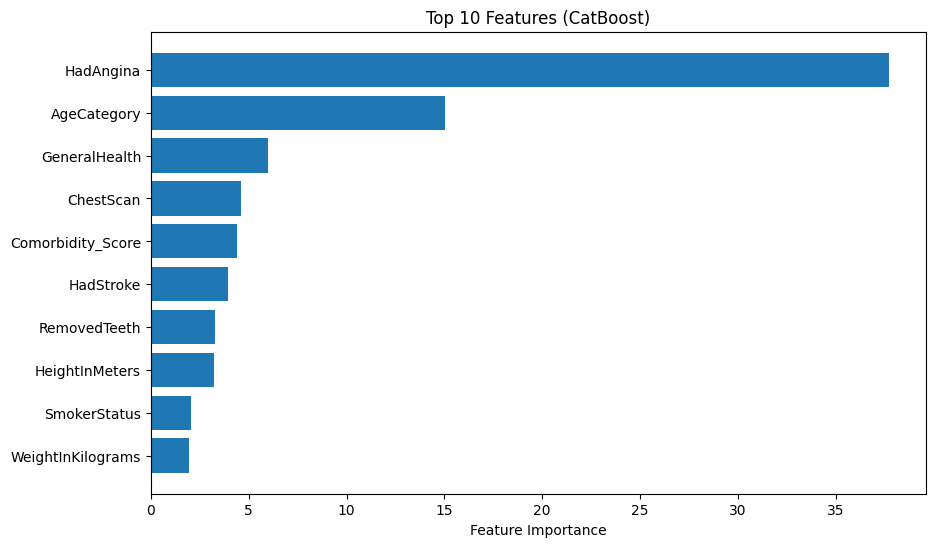

In [7]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. 定义 CatBoost 模型 ---
# 对于心脏病这种不平衡数据，auto_class_weights='Balanced' 是神器
# 它会自动给少数类(病人)加权重，你不需要手动算倍数了
cb_model = CatBoostClassifier(
    iterations=1000,            # 树的数量 (类似 n_estimators)
    learning_rate=0.03,         # 学习率 (越小越稳，但要配合大 iterations)
    depth=6,                    # 树深 (推荐 4-8 之间)
    eval_metric='AUC',          # 训练时监控 AUC 指标
    auto_class_weights='Balanced', # 关键！自动解决不平衡问题
    early_stopping_rounds=50,   # 如果 50 轮没提升就提前停止 (防过拟合)
    verbose=100,                # 每 100 次打印一下进度
    random_state=42
)

# --- 2. 训练模型 ---
# 注意：如果你保留了原始的字符串列(比如 'State'), 可以在这里加 cat_features参数
# 例如: cb_model.fit(X_train, y_train, cat_features=[0, 1, 5], ...)
print("开始训练 CatBoost...")
cb_model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True          # 训练完自动回滚到表现最好的一轮
)

# --- 3. 预测概率 ---
y_valid_proba_cb = cb_model.predict_proba(X_valid)[:, 1]

# --- 4. 看看基础表现 ---
print(f"\nROC-AUC Score: {roc_auc_score(y_valid, y_valid_proba_cb):.4f}")

# --- 5. 自动寻找最佳阈值 (用我们之前写的函数) ---
# 如果你之前定义过 find_optimal_threshold 直接调用就行
# 这里为了完整性我再放一次简化版
import numpy as np
from sklearn.metrics import precision_recall_curve

def get_best_threshold(y_true, y_prob, target_recall=0.95):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    # 找到 Recall >= 0.95 的所有点
    valid_points = np.where(recalls[:-1] >= target_recall)[0]
    if len(valid_points) > 0:
        # 在这些点里挑 Precision 最高的
        best_idx = valid_points[np.argmax(precisions[valid_points])]
        return thresholds[best_idx]
    return 0.5

best_thresh = get_best_threshold(y_valid, y_valid_proba_cb, target_recall=0.90) # 设个 90% 试试
print(f"推荐阈值: {best_thresh:.4f}")

# --- 6. 生成最终报告 ---
y_pred_cb = (y_valid_proba_cb >= best_thresh).astype(int)

print("\n--- CatBoost 最终表现 ---")
print(classification_report(y_valid, y_pred_cb))

# --- 7. (可选) 看看谁是重要特征 ---
feature_importance = cb_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[::-1] # 降序

plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importance[sorted_idx[:10]], align='center')
plt.yticks(range(10), X_train.columns[sorted_idx[:10]])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features (CatBoost)')
plt.gca().invert_yaxis() # 最重要的在上面
plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# 1. 准备数据
X = df.drop(columns=['HadHeartAttack'])
y = df['HadHeartAttack']

print(f"原始类别分布: {Counter(y)}")

# 2. 暴力欠采样 (让健康人和病人数量一样多)
# sampling_strategy=1.0 意味着 1:1，想要 1:2 可以设为 0.5
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print(f"欠采样后分布: {Counter(y_res)}")

# 3. 用这个只有几千行的数据去训练 CatBoost
cb_model.fit(
    X_res, y_res,
    eval_set=(X_valid, y_valid), # 验证集保持原样，不要动！
    use_best_model=True
)

# 4. 预测
y_prob = cb_model.predict_proba(X_valid)[:, 1]
# ...接着做评估...

📉 原始训练集分布: Counter({0.0: 333567, 1.0: 20086})
可以看到 0 (健康) 远多于 1 (心脏病)。

🔪 正在进行欠采样...
📉 欠采样后训练集分布: Counter({0.0: 20086, 1.0: 20086})
训练集大小从 353653 减少到了 40172

🚀 开始训练 CatBoost (Undersampled)...
0:	test: 0.8605682	best: 0.8605682 (0)	total: 8.39ms	remaining: 8.38s
100:	test: 0.8804774	best: 0.8804774 (100)	total: 757ms	remaining: 6.74s
200:	test: 0.8821174	best: 0.8821174 (200)	total: 1.48s	remaining: 5.9s
300:	test: 0.8826529	best: 0.8826529 (300)	total: 2.17s	remaining: 5.04s
400:	test: 0.8829252	best: 0.8829299 (393)	total: 2.84s	remaining: 4.24s
500:	test: 0.8831323	best: 0.8831350 (499)	total: 3.5s	remaining: 3.49s
600:	test: 0.8831964	best: 0.8832068 (591)	total: 4.19s	remaining: 2.78s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8832393357
bestIteration = 634

Shrink model to first 635 iterations.

📊 正在评估模型...
👉 ROC-AUC Score: 0.8832
⚖️ 推荐的最佳阈值 (Recall >= 90%): 0.3183

📝 最终分类报告 (Final Classification Report):
              precision    recall  f1-score   suppo

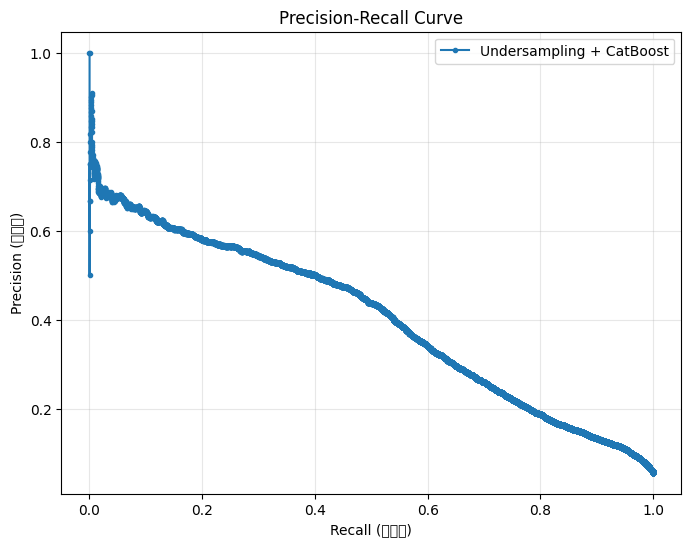

In [8]:
# ==========================================
# 方案一：暴力欠采样 (Undersampling) - 完整代码
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

# --- 1. 检查原来的不平衡情况 ---
print(f"📉 原始训练集分布: {Counter(y_train)}")
print("可以看到 0 (健康) 远多于 1 (心脏病)。")

# --- 2. 实施欠采样 (只针对训练集！) ---
# sampling_strategy=1.0 表示让 正负样本比例变成 1:1
# 如果觉得数据太少，可以设为 0.5 (即负样本是正样本的2倍)
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

print("\n🔪 正在进行欠采样...")
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print(f"📉 欠采样后训练集分布: {Counter(y_train_res)}")
print(f"训练集大小从 {len(X_train)} 减少到了 {len(X_train_res)}")

# --- 3. 训练 CatBoost ---
# 注意：现在我们用的是“平衡后的数据” (X_train_res) 训练
# 但是！验证集必须用“原始的不平衡数据” (X_valid)
# 这样才能知道模型在真实世界里表现如何

cb_model_rus = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=100,
    random_state=42,
    # 欠采样后数据已经平衡了，所以不需要 auto_class_weights='Balanced' 了
    # 但保留它也无妨，或者去掉也行
    auto_class_weights='Balanced' 
)

print("\n🚀 开始训练 CatBoost (Undersampled)...")
cb_model_rus.fit(
    X_train_res, y_train_res,
    eval_set=(X_valid, y_valid), # 关键：验证集不动
    use_best_model=True
)

# --- 4. 预测与评估 ---
print("\n📊 正在评估模型...")

# 拿到预测概率
y_prob_rus = cb_model_rus.predict_proba(X_valid)[:, 1]

# 看看 AUC
auc_score = roc_auc_score(y_valid, y_prob_rus)
print(f"👉 ROC-AUC Score: {auc_score:.4f}")

# --- 5. 自动寻找最佳阈值 (必做！) ---
# 欠采样后的模型通常会“过于敏感”，预测概率普遍偏高
# 所以必须重新找阈值，不能用 0.5

def get_best_threshold(y_true, y_prob, target_recall=0.90):
    """找到能满足 90% 召回率的阈值"""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    valid_points = np.where(recalls[:-1] >= target_recall)[0]
    if len(valid_points) > 0:
        best_idx = valid_points[np.argmax(precisions[valid_points])]
        return thresholds[best_idx]
    return 0.5

# 设定目标 Recall 为 90% (你可以改成 0.95)
best_thresh = get_best_threshold(y_valid, y_prob_rus, target_recall=0.90)
print(f"⚖️ 推荐的最佳阈值 (Recall >= 90%): {best_thresh:.4f}")

# --- 6. 最终分类报告 ---
y_pred_final = (y_prob_rus >= best_thresh).astype(int)

print("\n📝 最终分类报告 (Final Classification Report):")
print(classification_report(y_valid, y_pred_final))

# --- 7. 画个 PR 曲线看看真相 ---
precision, recall, _ = precision_recall_curve(y_valid, y_prob_rus)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Undersampling + CatBoost')
plt.xlabel('Recall (查全率)')
plt.ylabel('Precision (查准率)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()